# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

Lukáš Kaprál xkapra00

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [50]:
# TODO nacteni dat ze zip souboru

def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    for i, line in enumerate(f):
        line = line.decode("utf-8")
        if i == 0:
            line = line.replace("Configuration: ", "")
            data["conf"] = line.strip()
        elif i == 1:
            line = line.replace("Run: ", "")
            data["run"] = line.strip()
        elif i == 2:
            line = line.replace("Time of run: ", "")
            data["time"] = float(line.strip())     
    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
df = pd.DataFrame(data)
df

,conf,run,time
0,config1,0,104.967142
1,config1,1,98.617357
2,config1,2,106.476885
3,config1,3,115.230299
4,config1,4,97.658466
...,...,...,...
1195,config6,195,168.809495
1196,config6,196,159.607244
1197,config6,197,171.049799
1198,config6,198,164.478283


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

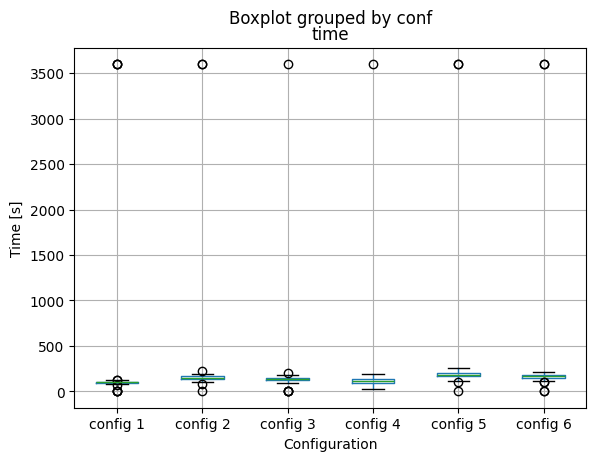

In [68]:
# TODO vykresleni grafu pro identifikace outlieru

boxplot = df.boxplot(column=["time"], by=["conf"])
new_xtick_labls = ["config 1","config 2","config 3","config 4","config 5","config 6",]
boxplot.set_xticklabels(new_xtick_labls)
boxplot.set_xlabel("Configuration")
boxplot.set_ylabel("Time [s]")
plt.show()

    

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

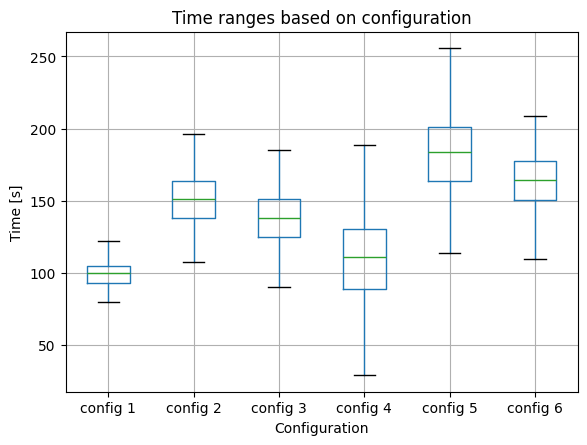

In [69]:
# TODO kod pro upravu dataframe tak, že tam tyto hodnoty nebudou:

grouped = df.groupby("conf")["time"]

data = {}
for conf, time in grouped:
    statistics = time.describe()
    IQR = statistics["75%"] - statistics["25%"]
    lower = statistics["25%"] - 1.5 * IQR
    upper = statistics["75%"] + 1.5 * IQR
    data[conf] = {
        'lower': lower,
        'upper': upper
    }
    
def filter_rows(row):
    conf = row['conf']
    time = row['time']
    if conf in data:
        conf_range = data[conf]
        lower_bound = conf_range['lower']
        upper_bound = conf_range['upper']
        if lower_bound <= time <= upper_bound:
            return True
    return False

filtered_df = df[df.apply(filter_rows, axis=1)]

boxplot = filtered_df.boxplot(column=["time"], by=["conf"])

new_xtick_labls = ["config 1","config 2","config 3","config 4","config 5","config 6",]
boxplot.set_xticklabels(new_xtick_labls)
boxplot.set_xlabel("Configuration")
boxplot.set_ylabel("Time [s]")

plt.suptitle("")
plt.title("Time ranges based on configuration")
plt.show()

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [53]:
# TODO deskriptivni parametry
a_mean = filtered_df["time"].mean()
w_mean = np.average(filtered_df["time"], weights=filtered_df["time"])
geo_mean = stats.gmean(filtered_df["time"])
median = filtered_df["time"].median()
quantile = filtered_df["time"].quantile()
std_deviation = filtered_df["time"].std()
variance = filtered_df["time"].var()
central_moment = stats.moment(filtered_df["time"], moment=4)
skewness = stats.skew(filtered_df["time"])
kurtosis = stats.kurtosis(filtered_df["time"])

descriptive_parameters = pd.DataFrame({"mean": [a_mean], "weighted mean": [w_mean], "geometric mean": [geo_mean], "median": [median], "quantile": [quantile], "standard deviation": [std_deviation], "variance": [variance], "central moment": [central_moment], "skewness": [skewness], "kurtosis": [kurtosis]})

descriptive_parameters

,mean,weighted mean,geometric mean,median,quantile,standard deviation,variance,central moment,skewness,kurtosis
0,141.300887,150.827315,136.205882,141.670525,141.670525,36.704853,1347.246205,4.966552e+06,0.107149,-0.259025


__OTÁZKA K DOPLNĚNÍ:__

Z tabulky můžeme vyčíst tyto hodnoty:
__mean__ je aritmetický průměr
__weighted mean__ je vážený průměr
__geometric mean__ je geometrický průměr
__median__ je medián
__quantile__ je kvartil
__standard deviation__ je směrodatná odchylka
__variance__ je rozptyl
__central moment__ n-tý centrální moment
__skewness__ je koeficient šikmosti
__kurtosis__ je koeficient špičatosti

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

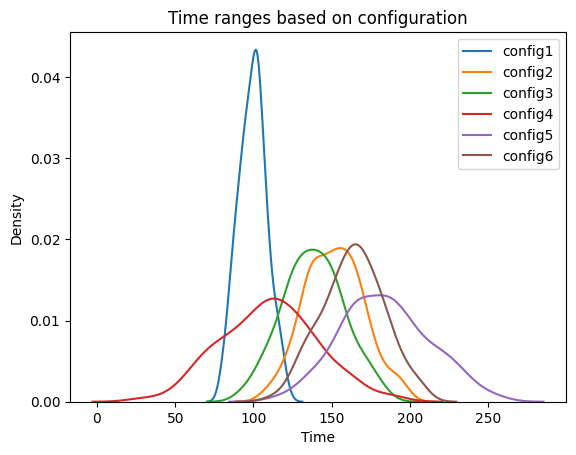

In [54]:
# TODO graf

grouped = filtered_df.groupby("conf")["time"]

for conf, time in grouped:
    #sns.distplot(time, hist=False, label=conf)
    sns.kdeplot(time, label=conf)

plt.legend()
plt.title("Time ranges based on configuration")
plt.xlabel("Time")
plt.show()





__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

In [55]:
# TODO: Implementace s vyuzitim knihovni funkce

grouped = df.groupby('conf')['time']

# Create a list of timing values for each configuration
configurations = [grouped.get_group(config).values for config in df['conf'].unique()]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*configurations)

# Interpret the results
alpha = 0.08  # significance level
if p_value < alpha:
    print("There is a statistically significant difference between configurations.")
    # Check which configuration is the fastest based on the means of timings
    means = [config.mean() for config in configurations]
    fastest_config = df['conf'].unique()[means.index(min(means))]
    print(f"The fastest configuration is: {fastest_config}")
else:
    print("There is no statistically significant difference between configurations.")

There is a statistically significant difference between configurations.
The fastest configuration is: config4


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

In [56]:
# TODO vlastni implementace zvoleneho testu